In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vtk_rw import read_vtk
import seaborn as sns
from plotting import plot_surf_stat_map
import matplotlib

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
def calculate_normals(vertices, faces):
    '''
    Calculate the normals of each vertex of a mesh
    as the weighted average of the normals of all faces
    it is part of
    '''
    
    triangles = vertices[faces]
    face_normals = np.cross( triangles[::,1 ] - triangles[::,0]  , triangles[::,2 ] - triangles[::,0] )
    face_normals /= 2 # weighting by surface area of the triangle, which is half the length of the normal
    
    vertex_normals = np.zeros(vertices.shape, dtype=vertices.dtype)
    vertex_count = np.zeros(vertices.shape[0])
    
    for face in range(faces.shape[0]):
        vertex_normals[faces[face]] += face_normals[face]
        vertex_count[faces[face]] += 1
   
    # divide by actual number of faces
    vertex_normals /= vertex_count[:, np.newaxis]
    
    return vertex_normals

In [5]:
def compare_normals(normals_a, normals_b):
    '''
    Calculate the angles between two sets of normals.
    Raises ValueError if any of the normals has length of 0
    '''

    # normalize normals
    normals_a /= np.linalg.norm(normals_a, axis=1)[:,np.newaxis]
    normals_b /= np.linalg.norm(normals_b, axis=1)[:,np.newaxis]
    
    if np.any(np.isnan(normals_a)):
        raise ValueError('NaN in first set of normals')
    elif np.any(np.isnan(normals_b)):
        raise ValueError('NaN in second set of normals')
    else:
        pass
    
    # calculate angle between each pair of normals in radians
    diff_dot = np.zeros((normals_a.shape[0],))
    diff_rad = np.zeros((normals_a.shape[0],))
    for i in range(normals_a.shape[0]):
        diff_dot[i] = np.dot(normals_a[i], normals_b[i])
    # if the dot product ends up being a very small float point bigger than 1, np.arccos returns NaN
    # therefore set those cases to 1
    diff_dot[np.where(diff_dot>1)] = 1.
    diff_rad = np.arccos(diff_dot)
    
    # transform to degree angle
    diff_deg = diff_rad  * (180/np.pi)
    
    return diff_rad, diff_deg

In [59]:
sns.set_context('notebook', font_scale=1.8)
sns.set_style('darkgrid')

### meshes

In [106]:
sub = 'HJJT'

In [107]:
simple_v, simple_f, _ = read_vtk('/scr/ilz3/myelinconnect/groupavg/indv_space/%s/lowres_rh_d_def.vtk'%sub)

In [108]:
simple_norms = calculate_normals(simple_v, simple_f)

In [109]:
complex_v, complex_f, _ = read_vtk('/scr/ilz3/myelinconnect/struct/surf_rh/orig/mid_surface/%s_rh_mid.vtk'%sub)

In [110]:
complex_norms = calculate_normals(complex_v, complex_f)

In [111]:
sulc = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy')

### mappings

In [112]:
mapping_orig = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/seeds/%s_rh_highres2lowres_seeds.npy'%sub)

In [113]:
mapping_tree = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/seeds_fixed/%s_rh_highres2lowres_seeds.npy'%sub)

In [114]:
#mapping_ideal = np.load('')

## Normals

### distributions

In [115]:
_, diff_orig = compare_normals(simple_norms, complex_norms[mapping_orig])

In [116]:
_, diff_tree = compare_normals(simple_norms, complex_norms[mapping_tree])

In [117]:
#_, diff_ideal = compare_normals(simple_norms, complex_norms[mapping_tree])

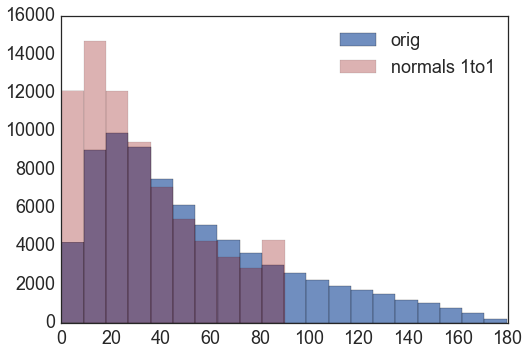

In [118]:
plt.hist(diff_orig, bins=20, alpha=0.8, label='orig');
plt.hist(diff_tree, bins=10, alpha=0.3, color='darkred', label='normals 1to1');
plt.legend()

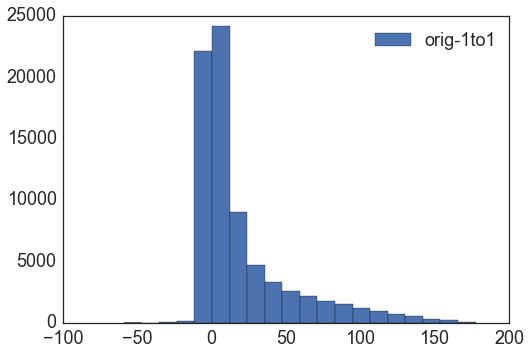

In [119]:
plt.hist((diff_orig - diff_tree), bins=20, label='orig-1to1') ;
#plt.hist(diff_orig - diff_ideal, bins=20, label='orig-ideal')
#plt.hist(diff_tree - diff_ideal, bins=20, label='1to1-ideal')
plt.legend()

### brains

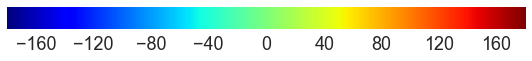

In [120]:
import matplotlib
sns.set_style('darkgrid')
norm = matplotlib.colors.Normalize(vmin=-180, vmax=180)
fig = plt.figure(figsize=(8, 2))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=plt.get_cmap('jet'),norm=norm,orientation='horizontal')

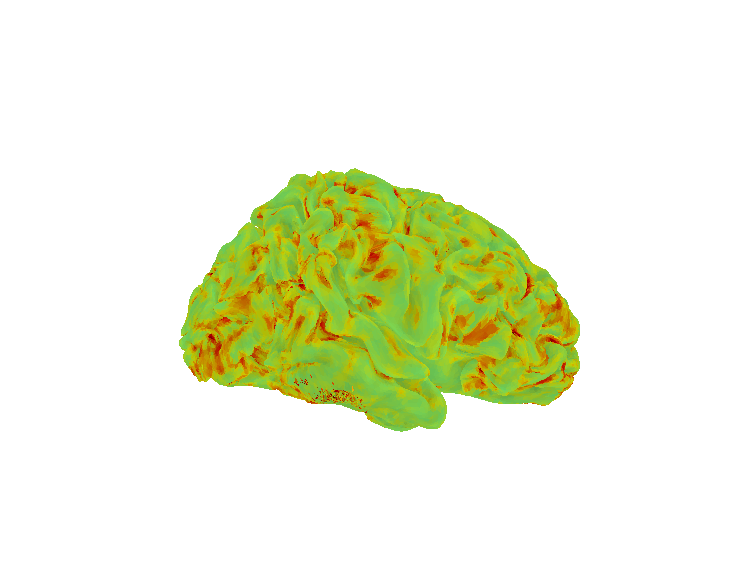

In [121]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_v, simple_f, stat_map=diff_orig, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.6,cmap='jet',elev=180,azim=0, figsize=(13,10), vmax=180)

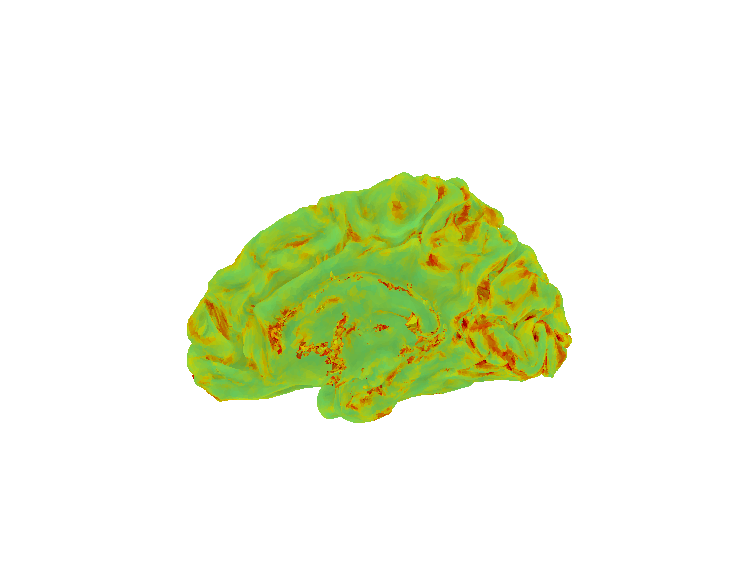

In [122]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_v, simple_f, stat_map=diff_orig, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.6,cmap='jet',elev=180,azim=180, figsize=(13,10), vmax=180)

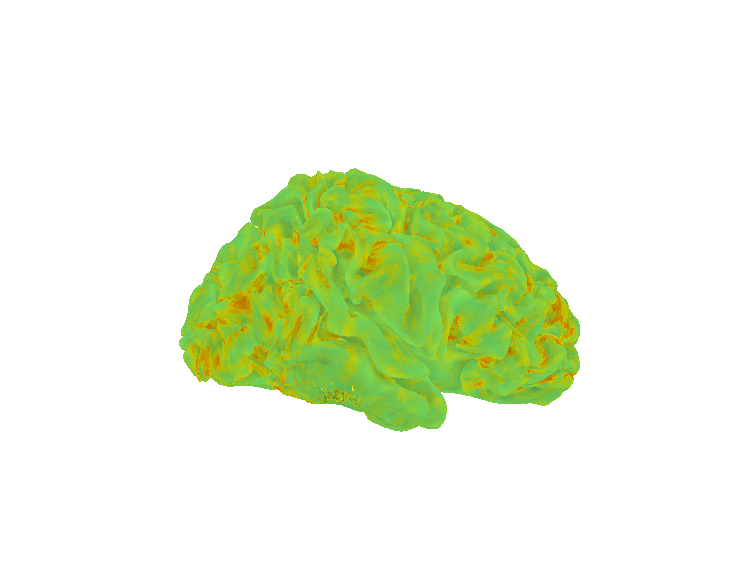

In [123]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_v, simple_f, stat_map=diff_tree, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.6,cmap='jet',elev=180,azim=0, figsize=(13,10), vmax=180)

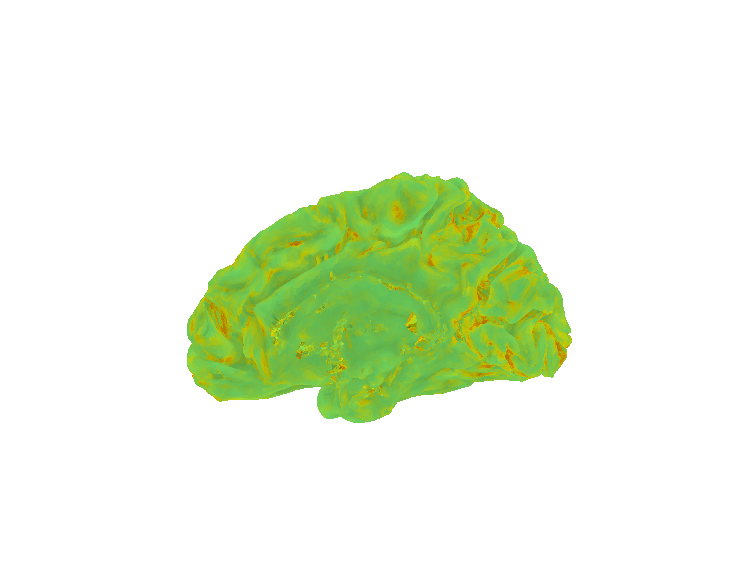

In [124]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_v, simple_f, stat_map=diff_tree, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.6,cmap='jet',elev=180,azim=180, figsize=(13,10), vmax=180)

## Distance

### distributions

In [125]:
dist_orig = np.linalg.norm((complex_v[mapping_orig] - simple_v), axis=1)

In [126]:
dist_tree = np.linalg.norm((complex_v[mapping_tree] - simple_v), axis=1)

In [127]:
#dist_ideal = np.linalg.norm((complex_v[mapping_ideal] - simple_v), axis=1)

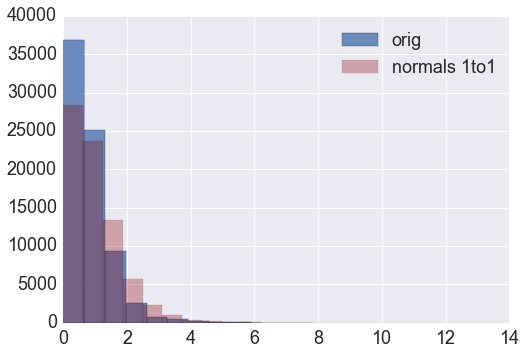

In [128]:
sns.set_style('darkgrid')
plt.hist(dist_orig, bins=12, alpha=0.8, label='orig');
plt.hist(dist_tree, bins=20, alpha=0.3, color='darkred', label='normals 1to1');
#plt.hist(dist_ideal, bins=20, alpha=0.3, color='darkgreen', label='ideal');
plt.legend()

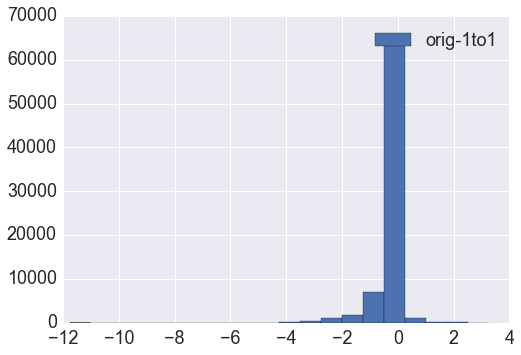

In [129]:
plt.hist((dist_orig - dist_tree), bins=20, label='orig-1to1');
#plt.hist(dist_orig - dist_ideal, bins=20, label='orig-ideal')
#plt.hist(dist_tree - dist_ideal, bins=20, label='1to1-ideal')
plt.legend()

### brains

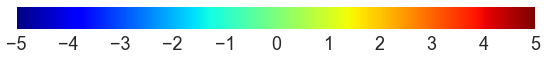

In [130]:
import matplotlib
sns.set_style('darkgrid')
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
fig = plt.figure(figsize=(8, 2))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=plt.get_cmap('jet'),norm=norm,orientation='horizontal')

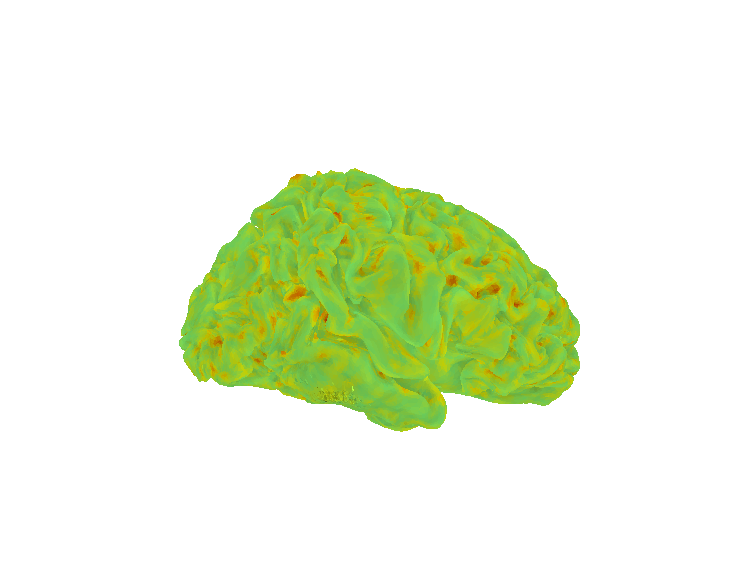

In [131]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_v, simple_f, stat_map=dist_orig, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.6,cmap='jet',elev=180,azim=0, figsize=(13,10), vmax=5)

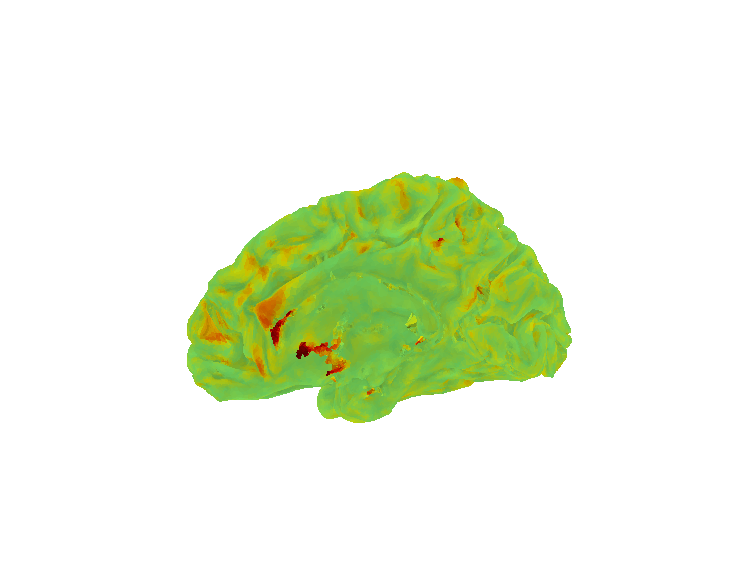

In [132]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_v, simple_f, stat_map=dist_orig, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.6,cmap='jet',elev=180,azim=180, figsize=(13,10), vmax=5)

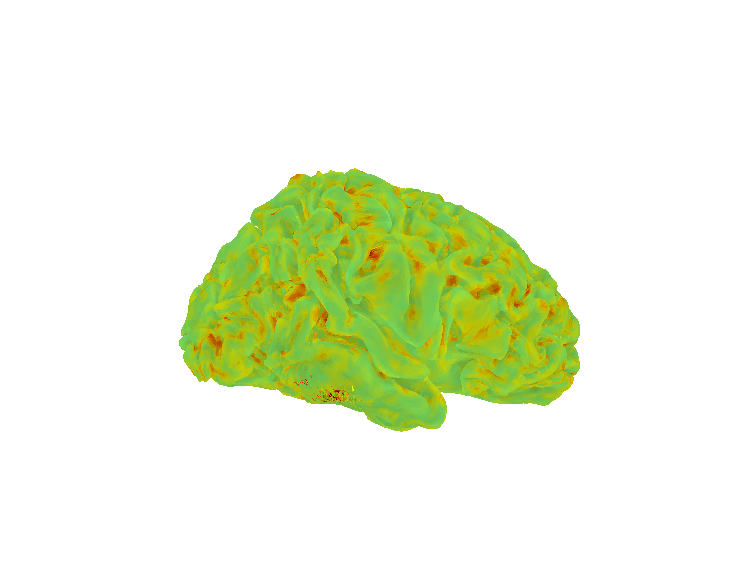

In [ ]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_v, simple_f, stat_map=dist_tree, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.6,cmap='jet',elev=180,azim=0, figsize=(13,10), vmax=5)

In [ ]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_v, simple_f, stat_map=dist_tree, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.6,cmap='jet',elev=180,azim=180, figsize=(13,10), vmax=5)